In [1]:
%matplotlib inline
import numpy as np
import nifty8 as ift
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
# plt.style.use("seaborn-notebook")

In [2]:
plt.rcParams['font.size'] = 18

In [3]:
N_pixels = 512     # Number of pixels

def pow_spec(k):
    P0, k0, gamma = [.2, 5, 4]
    return P0 / ((1. + (k/k0)**2)**(gamma / 2))

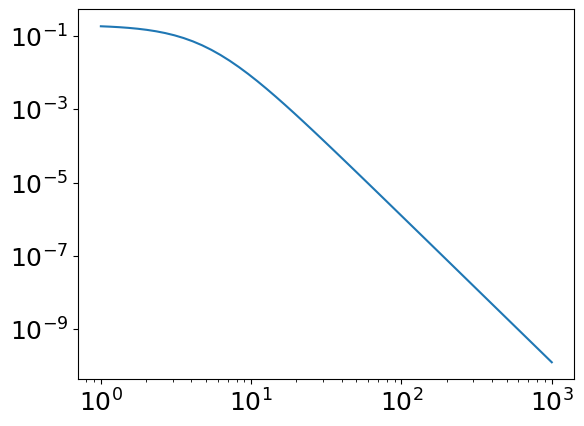

In [4]:
k = np.logspace(0, 3)
plt.loglog(k, pow_spec(k))

# Data model $$ d = Rs + n $$

### Noise model $$ n \sim \mathcal{G}(n, N) \implies \mathcal{P}(n) = \mathcal{G}(n; 0, N)$$

### Signal model (prior) $$ s \sim \mathcal{G}(s, S) \implies \mathcal{P}(s) = \mathcal{G}(s; 0, S)$$

### Data distribution $$ d \sim \delta(d - Rs)  \implies \mathcal{P}(d|n, s) = \delta \left(d - (Rs +n) \right)$$

## Likelihood $$ \mathcal{P}(d|s) = \int \mathcal{P}(d, n | s) dn = \int \mathcal{P}(d | n, s) \mathcal{P}(n)  dn$$ 
## $$ \mathcal{P}(d|s) = \int  \delta \left(d - (Rs + n) \right) \mathcal{G}(n, N) dn = \mathcal{G}(d - Rs, N) $$

## Joint $$ \mathcal{P}(s,d) = \mathcal{P}(d | s) \mathcal{P}(s) = \mathcal{G}(d - Rs, N) \mathcal{G}(s, S) = \mathcal{G}(s; m, D)$$

## $$ D  = \left(  R^\dagger N^{-1} R + S^{-1} \right)^{-1} $$
## $$ m = Dj = D R^\dagger N^{-1} d $$ where $$ j = R^\dagger N^{-1} d$$

## Posterior  $$ \mathcal{P}(s|d) = \frac{ \mathcal{P}(d | s) \mathcal{P}(s) }{ \mathcal{P}(d) } = \int \mathcal{P}(d | n, s) \mathcal{P}(n)  dn$$ 

In [5]:
def Curvature(R, N, Sh):
    IC = ift.GradientNormController(iteration_limit=50000,
                                    tol_abs_gradnorm=0.1)
    # WienerFilterCurvature is (R.adjoint*N.inverse*R + Sh.inverse) plus some handy
    # helper methods.
    return ift.WienerFilterCurvature(R,N,Sh,iteration_controller=IC,iteration_controller_sampling=IC)

In [ ]:
HT.

In [15]:
HT(Sh)

ChainOperator:
  HarmonicTransformOperator
  DiagonalOperator (domain/target shape: (512,), sampling dtype <class 'float'>)

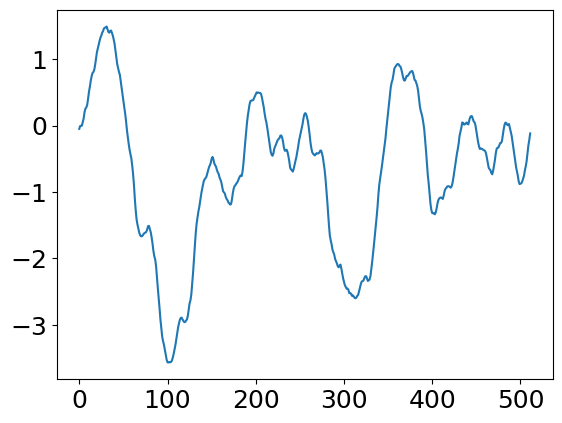

In [11]:
plt.plot(HT(Sh.draw_sample()).val)

In [17]:
1/N_pixels

0.001953125

In [18]:
s_space.total_volume

1.0

In [19]:
h_space.total_volume

512.0

In [6]:
s_space = ift.RGSpace(N_pixels)
h_space = s_space.get_default_codomain()
HT = ift.HarmonicTransformOperator(h_space, target=s_space)

# Operators
Sh = ift.create_power_operator(h_space, power_spectrum=pow_spec, sampling_dtype=float)
R = HT # @ ift.create_harmonic_smoothing_operator((h_space,), 0, 0.02)

# Fields and data
sh = Sh.draw_sample()
noiseless_data=R(sh)
noise_amplitude = np.sqrt(0.2)
N = ift.ScalingOperator(s_space, noise_amplitude**2, float)

n = ift.Field.from_random(domain=s_space, random_type='normal',
                          std=noise_amplitude, mean=0)
d = noiseless_data + n
j = R.adjoint_times(N.inverse_times(d))
curv = Curvature(R=R, N=N, Sh=Sh)
D = curv.inverse

In [10]:
m = D(j)

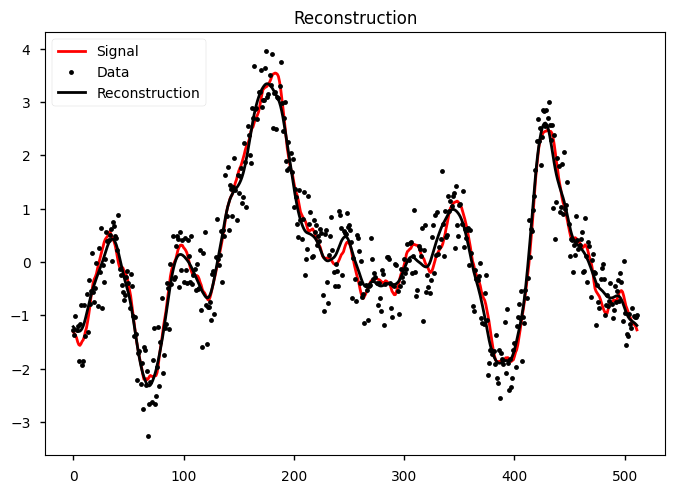

In [11]:
# Get signal data and reconstruction data
s_data = HT(sh).val
m_data = HT(m).val
d_data = d.val

plt.plot(s_data, 'r', label="Signal", linewidth=2)
plt.plot(d_data, 'k.', label="Data")
plt.plot(m_data, 'k', label="Reconstruction",linewidth=2)
plt.title("Reconstruction")
plt.legend()
plt.show()

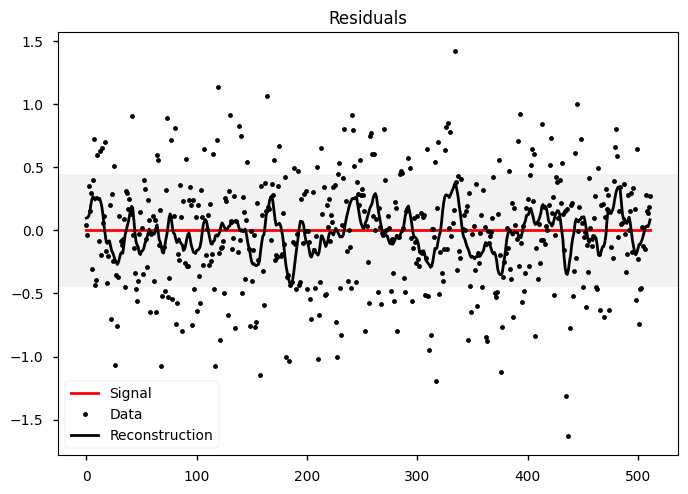

In [12]:
plt.plot(s_data - s_data, 'r', label="Signal", linewidth=2)
plt.plot(d_data - s_data, 'k.', label="Data")
plt.plot(m_data - s_data, 'k', label="Reconstruction",linewidth=2)
plt.axhspan(-noise_amplitude,noise_amplitude, facecolor='0.9', alpha=.5)
plt.title("Residuals")
plt.legend()
plt.show()

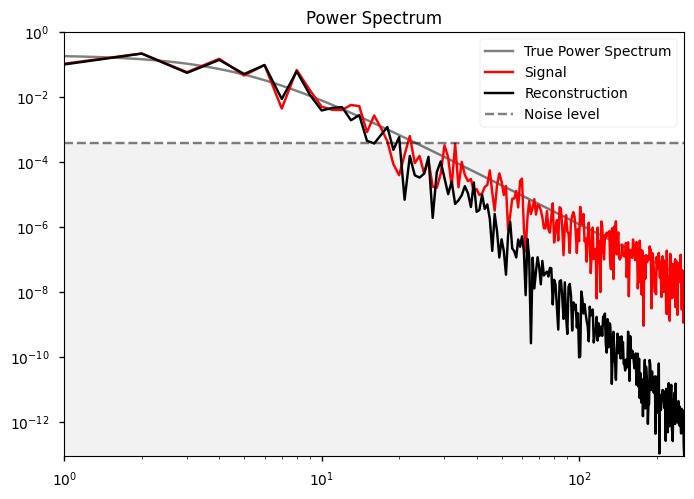

In [13]:
s_power_data = ift.power_analyze(sh).val
m_power_data = ift.power_analyze(m).val
plt.loglog()
plt.xlim(1, int(N_pixels/2))
ymin = min(m_power_data)
plt.ylim(ymin, 1)
xs = np.arange(1,int(N_pixels/2),.1)
plt.plot(xs, pow_spec(xs), label="True Power Spectrum", color='k',alpha=0.5)
plt.plot(s_power_data, 'r', label="Signal")
plt.plot(m_power_data, 'k', label="Reconstruction")
plt.axhline(noise_amplitude**2 / N_pixels, color="k", linestyle='--', label="Noise level", alpha=.5)
plt.axhspan(noise_amplitude**2 / N_pixels, ymin, facecolor='0.9', alpha=.5)
plt.title("Power Spectrum")
plt.legend()
plt.show()

In [14]:
# Operators
Sh = ift.create_power_operator(h_space, power_spectrum=pow_spec, sampling_dtype=float)
N = ift.ScalingOperator(s_space, noise_amplitude**2, sampling_dtype=float)
# R is defined below

# Fields
sh = Sh.draw_sample()
s = HT(sh)
n = ift.Field.from_random(domain=s_space, random_type='normal',
                      std=noise_amplitude, mean=0)

In [15]:
l = int(N_pixels * 0.2)
h = int(N_pixels * 0.2 * 2)

mask = np.full(s_space.shape, 1.)
mask[l:h] = 0
mask = ift.Field.from_raw(s_space, mask)

R = ift.DiagonalOperator(mask) @ HT
n = n.val_rw()
n[l:h] = 0
n = ift.Field.from_raw(s_space, n)

d = R(sh) + n

In [16]:
curv = Curvature(R=R, N=N, Sh=Sh)
D = curv.inverse
j = R.adjoint_times(N.inverse_times(d))
m = D(j)

In [17]:
m_mean, m_var = ift.probe_with_posterior_samples(curv, HT, 200, np.float64)

In [18]:
# Get signal data and reconstruction data
s_data = s.val
m_data = HT(m).val
m_var_data = m_var.val
uncertainty = np.sqrt(m_var_data)
d_data = d.val_rw()

# Set lost data to NaN for proper plotting
d_data[d_data == 0] = np.nan

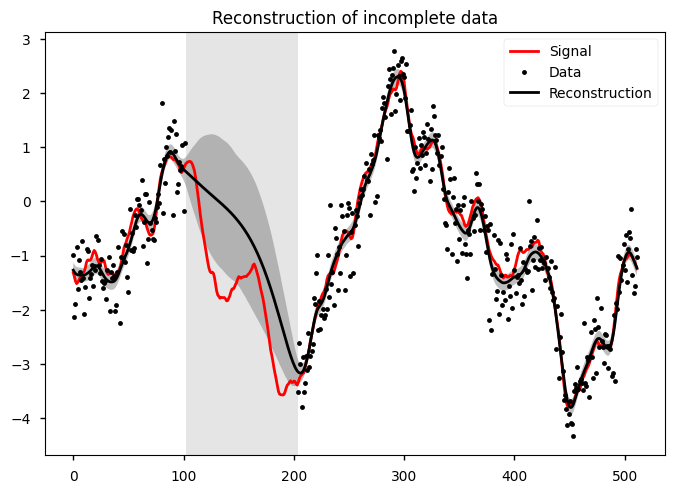

In [19]:
plt.axvspan(l, h, facecolor='0.8',alpha=0.5)
plt.fill_between(range(N_pixels), m_data - uncertainty, m_data + uncertainty, facecolor='0.5', alpha=0.5)
plt.plot(s_data, 'r', label="Signal", alpha=1, linewidth=2)
plt.plot(d_data, 'k.', label="Data")
plt.plot(m_data, 'k', label="Reconstruction", linewidth=2)
plt.title("Reconstruction of incomplete data")
plt.legend()

In [21]:
N_pixels = 256      # Number of pixels
sigma2 = 2.         # Noise variance

def pow_spec(k):
    P0, k0, gamma = [.2, 2, 4]
    return P0 * (1. + (k/k0)**2)**(-gamma/2)

s_space = ift.RGSpace([N_pixels, N_pixels])

In [22]:
h_space = s_space.get_default_codomain()
HT = ift.HarmonicTransformOperator(h_space,s_space)

# Operators
Sh = ift.create_power_operator(h_space, power_spectrum=pow_spec, sampling_dtype=float)
N = ift.ScalingOperator(s_space, sigma2, sampling_dtype=float)

# Fields and data
sh = Sh.draw_sample()
n = ift.Field.from_random(domain=s_space, random_type='normal',
                      std=np.sqrt(sigma2), mean=0)

# Lose some data

l = int(N_pixels * 0.33)
h = int(N_pixels * 0.33 * 2)

mask = np.full(s_space.shape, 1.)
mask[l:h,l:h] = 0.
mask = ift.Field.from_raw(s_space, mask)

R = ift.DiagonalOperator(mask)(HT)
n = n.val_rw()
n[l:h, l:h] = 0
n = ift.Field.from_raw(s_space, n)
curv = Curvature(R=R, N=N, Sh=Sh)
D = curv.inverse

d = R(sh) + n
j = R.adjoint_times(N.inverse_times(d))

# Run Wiener filter
m = D(j)

# Uncertainty
m_mean, m_var = ift.probe_with_posterior_samples(curv, HT, 20, np.float64)

# Get data
s_data = HT(sh).val
m_data = HT(m).val
m_var_data = m_var.val
d_data = d.val
uncertainty = np.sqrt(np.abs(m_var_data))

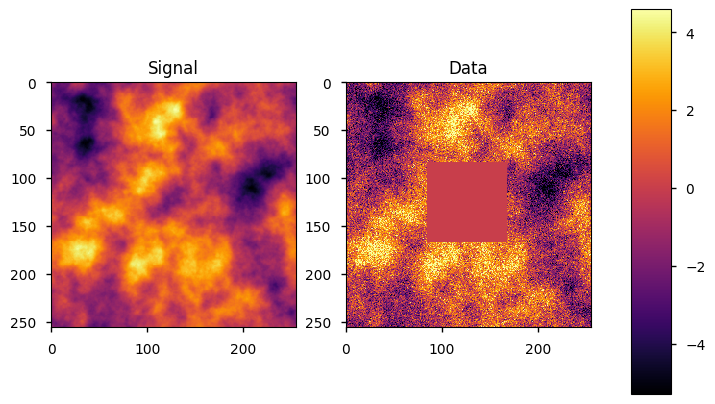

In [23]:
cmap = ['magma', 'inferno', 'plasma', 'viridis'][1]

mi = np.min(s_data)
ma = np.max(s_data)

fig, axes = plt.subplots(1, 2)

data = [s_data, d_data]
caption = ["Signal", "Data"]

for ax in axes.flat:
    im = ax.imshow(data.pop(0), interpolation='nearest', cmap=cmap, vmin=mi,
                   vmax=ma)
    ax.set_title(caption.pop(0))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

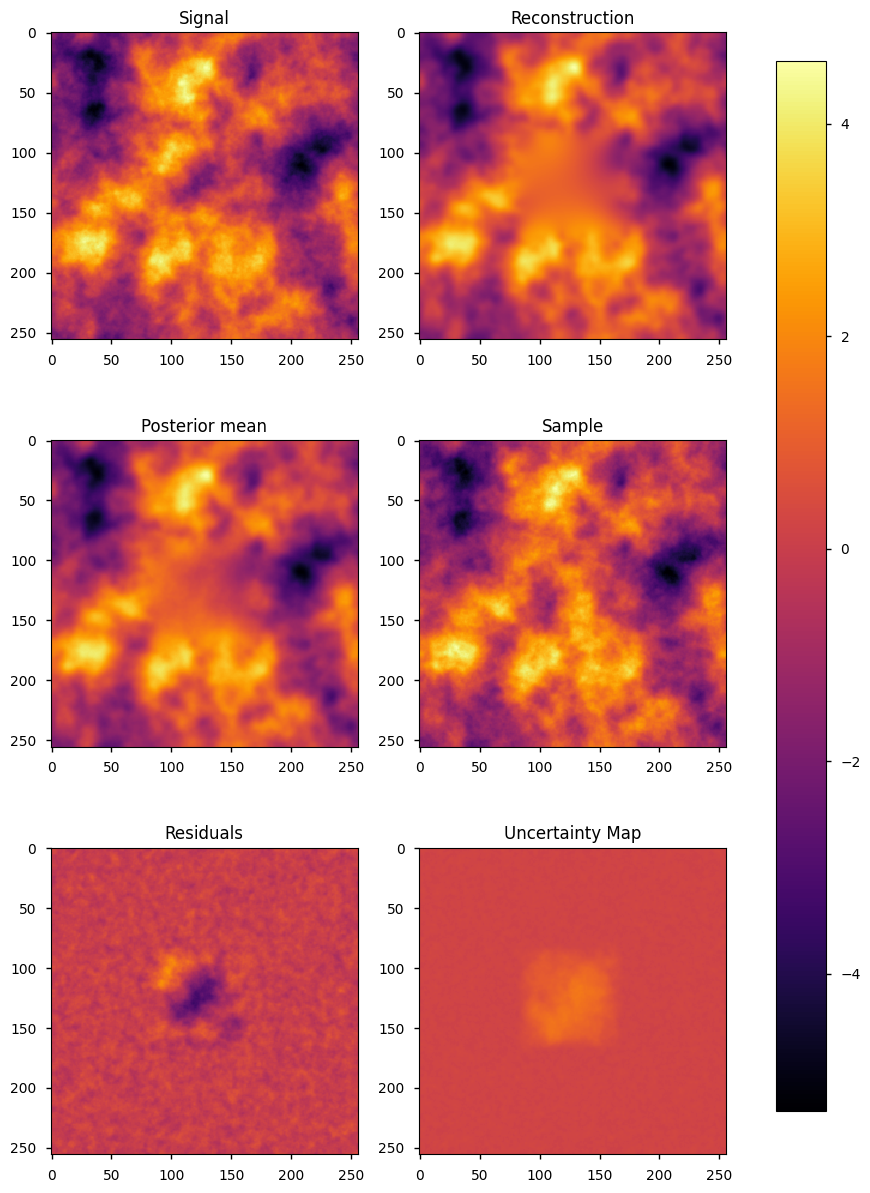

In [24]:
mi = np.min(s_data)
ma = np.max(s_data)

fig, axes = plt.subplots(3, 2, figsize=(10, 15))
sample = HT(curv.draw_sample(from_inverse=True)+m).val
post_mean = (m_mean + HT(m)).val

data = [s_data, m_data, post_mean, sample, s_data - m_data, uncertainty]
caption = ["Signal", "Reconstruction", "Posterior mean", "Sample", "Residuals", "Uncertainty Map"]

for ax in axes.flat:
    im = ax.imshow(data.pop(0), interpolation='nearest', cmap=cmap, vmin=mi, vmax=ma)
    ax.set_title(caption.pop(0))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

Error within uncertainty map bounds: 67.71392822265625%


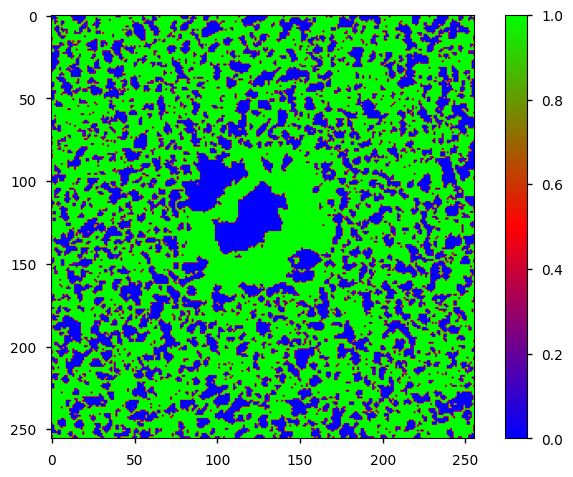

In [25]:
precise = (np.abs(s_data-m_data) < uncertainty)
print("Error within uncertainty map bounds: " + str(np.sum(precise) * 100 / N_pixels**2) + "%")

plt.imshow(precise.astype(float), cmap="brg")
plt.colorbar()